In [ ]:
# todo: figure out how to get saliency for transformer
# can we match CLIP performance with VB?

In [1]:
from mmf.utils.env import import_user_module
%load_ext autoreload
%autoreload 2
import_user_module("/home/g-luo/remote_home/foil_mmf")
import numpy as np
from PIL import Image
import torch
from torchray.attribution.grad_cam import grad_cam
from miniclip.imageWrangle import heatmap, heatmap_helper, min_max_norm, torch_to_rgba
import matplotlib.pyplot as plt
import json

def get_feat(ann):
    base = "/shared/g-luo/visual_news_metadata/features/"
    rest = ann["image_path"].replace("./", "").replace(".jpg", "_info.npy").replace("images", "features")
    return base + rest

def get_categories():
    categories_unprocessed = json.load(open("../foil_mmf/etc/visual_genome_categories.json"))
    categories = {cat["id"]: cat["name"] for cat in categories_unprocessed["categories"]}
    return categories

device = "cuda" if torch.cuda.is_available() else "cpu"
label_categories = get_categories()

In [123]:
import sys
# sys.path.append("../foil_mmf/foil/models")
from natural_language_joint_query_search.CLIP import clip

In [124]:
import os
os.environ["CUDA_VISIBLE_DEVICES"]="4"
rn50_dir = "/shared/g-luo/tarasque/emnlp/RN50_freeze_lower/merged_balanced_clip_rn50_freeze_lower/"

In [125]:
predictions = json.load(open("../foil_mmf/val/merged_balanced_clip_rn50_freeze_lower/foil_clip_2/reports/val.json"))
predictions = {ann["id"]:ann for ann in predictions}

In [126]:
import torch
from collections import OrderedDict

device = "cuda"
def get_model(load_weights=True, model_dir=""):
    model, preprocess =  clip.load("RN50", device=device, jit=False)
    if load_weights:
        print("Loaded")
        state_dict = torch.load(f"{model_dir}")
        lst = []
        for key in state_dict["model"]:
            new_key = key.replace("model.", "")
            if "classifier" not in new_key:
                lst.append((new_key, state_dict["model"][key]))
        model.load_state_dict(OrderedDict(lst))
        model.to("cuda")
        model.eval()
    return model, preprocess

finetuned_model, preprocess = get_model(load_weights=True, model_dir=rn50_dir + "best.ckpt")
finetuned_model = finetuned_model.float()

original_model, _ = get_model(load_weights=False)
original_model = original_model.float()

Loaded


In [6]:
# from foil_mmf.foil.models.clip import CLIP
# from mmf.utils.configuration import load_yaml_with_defaults

# conf = load_yaml_with_defaults(rn50_dir + "config.yaml")
# classification_model = CLIP(conf.model_config.clip)
# classification_model.build()

# state_dict = torch.load(rn50_dir + "/best.ckpt")
# classification_model.load_state_dict(state_dict["model"])
# classification_model.to("cuda")
# classification_model.eval()

In [127]:
import json
import numpy as np
option = "merged/balanced_disjoint_ents_quad"
dataset_type = "val"
dataset = json.load(open(f"/home/g-luo/.cache/torch/mmf/data/datasets/foil/defaults/annotations/visualnews_foil/{option}/{dataset_type}.json"))["annotations"]
metadata = json.load(open(f"/shared/g-luo/visual_news_metadata/visualnews_foil/full_split/data/{dataset_type}.json"))

In [128]:
ents = {ann["id"]:ann["caption_entities"] for ann in metadata}

In [129]:
# https://github.com/openai/CLIP/issues/18
# TODO: figure out saliency for ViT-B32

In [130]:
alpha = [0.5, 0.7, 0.8][0]
layer = 'layer4.2.relu'
def get_grad_cam(model, image, text):
    with torch.no_grad():
        image_features = model.encode_image(image)
        text_features, _ = model.encode_text(text)
        image_features_norm = image_features.norm(dim=-1, keepdim=True)
        image_features_new = image_features / image_features_norm
        text_features_norm = text_features.norm(dim=-1, keepdim=True)
        text_features_new = text_features / text_features_norm
        logit_scale = model.logit_scale.exp()
        logits_per_image = logit_scale * image_features_new @ text_features_new.t()
        probs = logits_per_image.softmax(dim=-1).cpu().numpy().tolist()

    saliency = grad_cam(model.visual, image.type(model.dtype), image_features, saliency_layer=layer)
    hm = heatmap(image[0], saliency[0][0,].detach().type(torch.float32).cpu(), alpha=alpha)

    collect_images, saliencies = [], []
    for i in range(len(categories)):
        # mutliply the normalized text embedding with image norm to get approx image embedding
        text_prediction = (text_features_new[[i]] * image_features_norm)
        saliency = grad_cam(model.visual, image.type(model.dtype), text_prediction, saliency_layer=layer)
        hm_helper = heatmap_helper(image[0], saliency[0][0,].detach().type(torch.float32).cpu(), alpha=alpha)
        hm = heatmap(image[0], saliency[0][0,].detach().type(torch.float32).cpu(), alpha=alpha)
        collect_images.append(hm)
        saliencies.append(hm_helper)
    logits = logits_per_image.cpu().numpy().tolist()[0]
    titles = [f"{x} - {str(round(y, 3))}/{str(round(l, 2))}" for (x, y, l) in zip(categories, probs[0], logits)]
    return titles, collect_images, saliencies

In [131]:
import matplotlib.pyplot as plt 
from PIL import Image
import matplotlib.patches as patches
import torch, os

# get the proportion of times that the attn lands in each bbox
def get_attention_bbox(ann, saliency, threshold=0.5):
    saliency = saliency / np.sum(saliency)
    img_info = np.load(get_feat(ann), allow_pickle=True).item()
    img_path = "/shared/g-luo/visual_news/origin/" + ann["image_path"].split("./")[1]
    img = Image.open(img_path)
    img_array = torch_to_rgba(image[0])

    # bboxes have no need for normalization
    weights = []
    for i in range(100):
        if img_info["cls_prob"][i].max() < threshold:
            continue
        w, h = img_info["image_width"], img_info["image_height"]
        x1, y1, x2, y2 = img_info["bbox"][i]
        x1, y1, x2, y2 = int(x1), int(y1), int(x2), int(y2)

        label_idx = np.argmax(img_info["cls_prob"][i])
        label = label_categories[label_idx]
        
        weights.append((label, np.sum(saliency[x1:x2, y1:y2])))
    print(max(weights, key=lambda x:x[1]))

In [173]:
# Taken from https://github.com/pytorch/captum/blob/master/captum/attr/_utils/visualization.py
from IPython.core.display import HTML, display
def _get_color(attr):
    # clip values to prevent CSS errors (Values should be from [-1,1])
    attr = max(-1, min(1, attr))
    if attr > 0:
        hue = 120
        sat = 75
        lig = 100 - int(50 * attr)
    else:
        hue = 0
        sat = 75
        lig = 100 - int(-40 * attr)
    return "hsl({}, {}%, {}%)".format(hue, sat, lig)

def format_special_tokens(token):
    if token.startswith("<") and token.endswith(">"):
        return "#" + token.strip("<>")
    return token

def format_word_importances(words, importances):
    if importances is None or len(importances) == 0:
        return "<td></td>"
    assert len(words) <= len(importances)
    tags = ["<td>"]
    for word, importance in zip(words, importances[: len(words)]):
        word = format_special_tokens(word)
        color = _get_color(importance)
        unwrapped_tag = '<mark style="background-color: {color}; opacity:1.0; \
                    line-height:1.75"><font color="black"> {word}\
                    </font></mark>'.format(
            color=color, word=word
        )
        tags.append(unwrapped_tag)
    tags.append("</td>")
    return "".join(tags)

def visualize_text(
    datarecords, title
) -> "HTML":  # In quotes because this type doesn't exist in standalone mode
    dom = ["<table width: 100%>"]
    rows = [
        "<th>" + title + "</th>"
    ]
    for datarecord in datarecords:
        rows.append(
            "".join(
                [
                    "<tr>",
                    format_word_importances(
                        datarecord.raw_input, datarecord.word_attributions
                    ),
                    "<tr>",
                ]
            )
        )

    dom.append("".join(rows))
    dom.append("</table>")
    html = HTML("".join(dom))
    display(html)

    return html

In [180]:
import seaborn as sns
from captum.attr import visualization
def get_text_scores(model, image, ann, title):
    words = ann["caption"].split(" ")
    text = clip.tokenize(ann["caption"]).to(device)
    with torch.no_grad():
        image_features = model.encode_image(image)
        text_features, weight = model.encode_text(text)
        
    attention_weights = list(weight[-1][0][1+len(words)].cpu().numpy())[:2+len(words)][1:][:-1]
    attention_weights = [float(item) for item in attention_weights]
#     scores = (image_features @ text_features.T).cpu().numpy()[0]
#     scores = scores / np.sum(scores)
#     #words = np.expand_dims(np.array(words), 0)
#     print(scores)
    vis_data_records = [visualization.VisualizationDataRecord(attention_weights,0,0,0,0,0,words,1)]
    visualize_text(vis_data_records, title)

1453390
Caption:  Credit Suisse is one of the 14 Swiss banks being chased by US prosecutors for allegedly helping wealthy Americans avoid US taxes
Image Caption:  ORIG



Credit Suisse is one of the 14 Swiss banks being chased by US prosecutors for allegedly helping wealthy Americans avoid US taxes


Credit Suisse is one of the 14 Swiss banks being chased by US prosecutors for allegedly helping wealthy Americans avoid US taxes


Target  0 Prediction  1
 


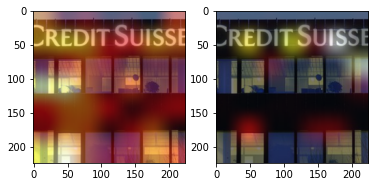

1453390
Caption:  Credit Suisse is one of the 14 Swiss banks being chased by US prosecutors for allegedly helping wealthy Americans avoid US taxes
Image Caption:  Royal Bank of Scotland is axing 690 jobs 500 in its Telford debt management office



Credit Suisse is one of the 14 Swiss banks being chased by US prosecutors for allegedly helping wealthy Americans avoid US taxes


Credit Suisse is one of the 14 Swiss banks being chased by US prosecutors for allegedly helping wealthy Americans avoid US taxes


Target  1 Prediction  1
 


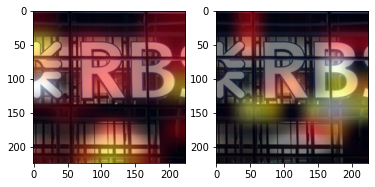

535446
Caption:  MND Association s LastSummer poster campaign
Image Caption:  ORIG



MND Association s LastSummer poster campaign


MND Association s LastSummer poster campaign


Target  0 Prediction  0
 


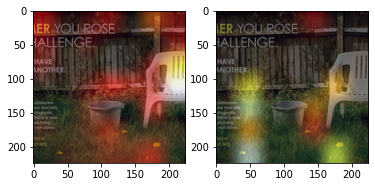

535446
Caption:  MND Association s LastSummer poster campaign
Image Caption:  Munich 1860 s new Oktoberfest kit



MND Association s LastSummer poster campaign


MND Association s LastSummer poster campaign


Target  1 Prediction  1
 


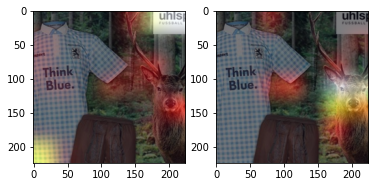

117584
Caption:  A Chipotle restaurant in Miami
Image Caption:  ORIG



A Chipotle restaurant in Miami


A Chipotle restaurant in Miami


Target  0 Prediction  1
 


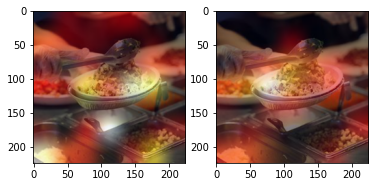

117584
Caption:  A Chipotle restaurant in Miami
Image Caption:  The steak frites at Norda comes with chile and parmesan fries and is served in a tarragon emulsion with tomato and herbs



A Chipotle restaurant in Miami


A Chipotle restaurant in Miami


Target  1 Prediction  0
 


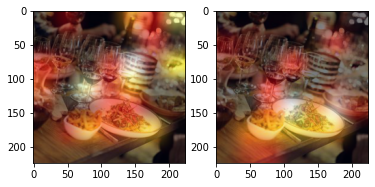

1522244
Caption:  Naples and Mount Vesuvius Sentinel data will track environmental change but also inform and help enforce EU policy
Image Caption:  ORIG



Naples and Mount Vesuvius Sentinel data will track environmental change but also inform and help enforce EU policy


Naples and Mount Vesuvius Sentinel data will track environmental change but also inform and help enforce EU policy


Target  0 Prediction  1
 


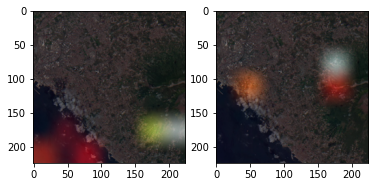

1522244
Caption:  Naples and Mount Vesuvius Sentinel data will track environmental change but also inform and help enforce EU policy
Image Caption:  The quake was felt in parts of south Wales Devon and Somerset



Naples and Mount Vesuvius Sentinel data will track environmental change but also inform and help enforce EU policy


Naples and Mount Vesuvius Sentinel data will track environmental change but also inform and help enforce EU policy


Target  1 Prediction  1
 


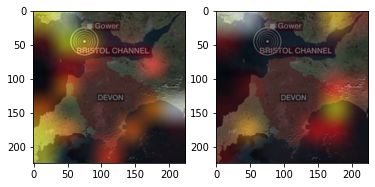

1457672
Caption:  A UK boy had appeared at Westminster Magistrates Court earlier this year
Image Caption:  ORIG



A UK boy had appeared at Westminster Magistrates Court earlier this year


A UK boy had appeared at Westminster Magistrates Court earlier this year


Target  0 Prediction  1
 


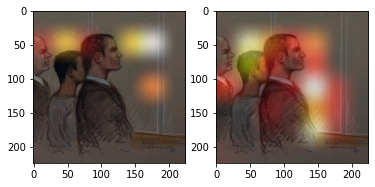

1457672
Caption:  A UK boy had appeared at Westminster Magistrates Court earlier this year
Image Caption:  The MPs used a Commons debate to discuss Scottish independence



A UK boy had appeared at Westminster Magistrates Court earlier this year


A UK boy had appeared at Westminster Magistrates Court earlier this year


Target  1 Prediction  0
 


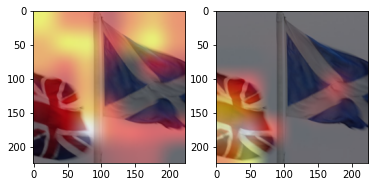

216488
Caption:  Massachusetts Bay Transportation Authority trains sit idle early Saturday in Boston
Image Caption:  ORIG



Massachusetts Bay Transportation Authority trains sit idle early Saturday in Boston


Massachusetts Bay Transportation Authority trains sit idle early Saturday in Boston


Target  0 Prediction  0
 


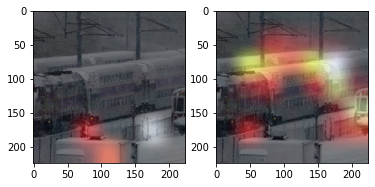

216488
Caption:  Massachusetts Bay Transportation Authority trains sit idle early Saturday in Boston
Image Caption:  Improved links from Norwich to London could help win votes



Massachusetts Bay Transportation Authority trains sit idle early Saturday in Boston


Massachusetts Bay Transportation Authority trains sit idle early Saturday in Boston


Target  1 Prediction  1
 


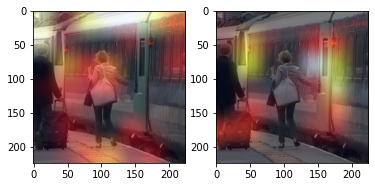

198442
Caption:  A Burkina Faso gendarme stands guard next to burnt cars outside the Splendid Hotel in Ouagadougou on Monday after a deadly attack by alQaedalinked gunmen late Friday
Image Caption:  ORIG



Target  0 Prediction  0
 


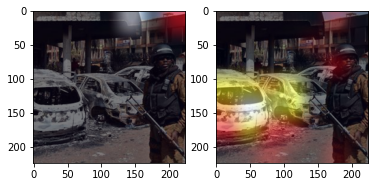

198442
Caption:  A Burkina Faso gendarme stands guard next to burnt cars outside the Splendid Hotel in Ouagadougou on Monday after a deadly attack by alQaedalinked gunmen late Friday
Image Caption:  A villager surveys his home wrecked by shelling in Semyonovka in Luhansk district



Target  1 Prediction  1
 


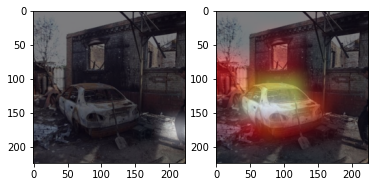

243264
Caption:  Young Nubian goats arrived at Fort Hancock in Sandy Hook NJ in July 2013 to help eradicate the infestation of poison ivy in and around the mortar batteries
Image Caption:  ORIG



Target  0 Prediction  0
 


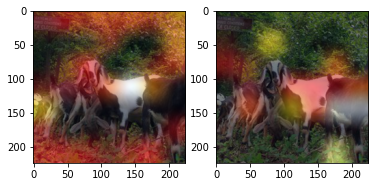

243264
Caption:  Young Nubian goats arrived at Fort Hancock in Sandy Hook NJ in July 2013 to help eradicate the infestation of poison ivy in and around the mortar batteries
Image Caption:  Two newborn Przewalski s foals explore their pasture at the National Zoo s Conservation and Research Center



Target  1 Prediction  1
 


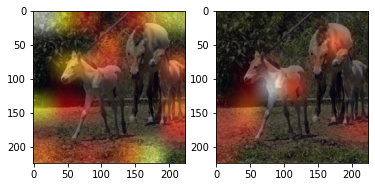

671084
Caption:  The bedroom tax has led to tensions within the Rochdale community after rumours that Muslim families were exempt from the policy were circulated online
Image Caption:  ORIG



The bedroom tax has led to tensions within the Rochdale community after rumours that Muslim families were exempt from the policy were circulated online


The bedroom tax has led to tensions within the Rochdale community after rumours that Muslim families were exempt from the policy were circulated online


Target  0 Prediction  0
 


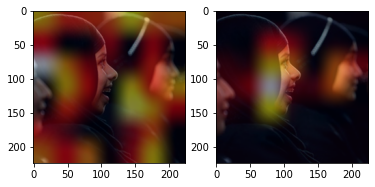

671084
Caption:  The bedroom tax has led to tensions within the Rochdale community after rumours that Muslim families were exempt from the policy were circulated online
Image Caption:  Syrians make up the largest group of people arriving in Europe looking for asylum



The bedroom tax has led to tensions within the Rochdale community after rumours that Muslim families were exempt from the policy were circulated online


The bedroom tax has led to tensions within the Rochdale community after rumours that Muslim families were exempt from the policy were circulated online


Target  1 Prediction  1
 


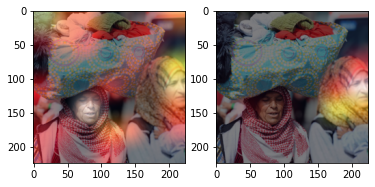

452802
Caption:  Students stand in the doorway of Ranrra school in Rawalpindi Pakistan before a special class is given about the Peshawar attack
Image Caption:  ORIG



Students stand in the doorway of Ranrra school in Rawalpindi Pakistan before a special class is given about the Peshawar attack


Students stand in the doorway of Ranrra school in Rawalpindi Pakistan before a special class is given about the Peshawar attack


Target  0 Prediction  1
 


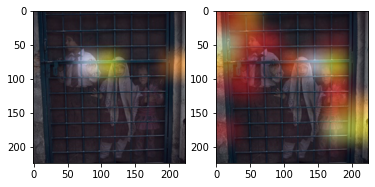

452802
Caption:  Students stand in the doorway of Ranrra school in Rawalpindi Pakistan before a special class is given about the Peshawar attack
Image Caption:  Pakistani students sing as they hold pictures of Malala Yousufzai during a rally at the Pakistani Embassy on Monday in Abu Dhabi United Arab Emirates



Students stand in the doorway of Ranrra school in Rawalpindi Pakistan before a special class is given about the Peshawar attack


Students stand in the doorway of Ranrra school in Rawalpindi Pakistan before a special class is given about the Peshawar attack


Target  1 Prediction  1
 


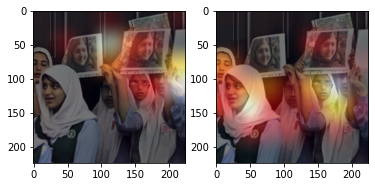

695286
Caption:  Two vaquitas in the upper gulf of california Mexico Click here for all actions for the Americas
Image Caption:  ORIG



Two vaquitas in the upper gulf of california Mexico Click here for all actions for the Americas


Two vaquitas in the upper gulf of california Mexico Click here for all actions for the Americas


Target  0 Prediction  1
 


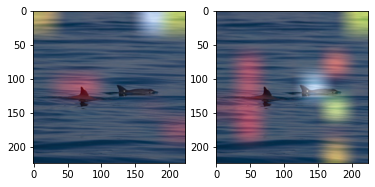

695286
Caption:  Two vaquitas in the upper gulf of california Mexico Click here for all actions for the Americas
Image Caption:  Skokholm is one of the most important sites for Manx shearwater birds in the world



Two vaquitas in the upper gulf of california Mexico Click here for all actions for the Americas


Two vaquitas in the upper gulf of california Mexico Click here for all actions for the Americas


Target  1 Prediction  0
 


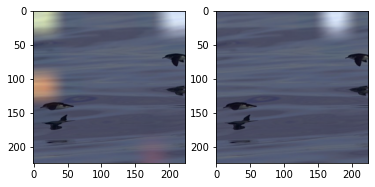

832056
Caption:  Environmental Protection Agency building in Washington DC
Image Caption:  ORIG



Environmental Protection Agency building in Washington DC


Environmental Protection Agency building in Washington DC


Target  0 Prediction  1
 


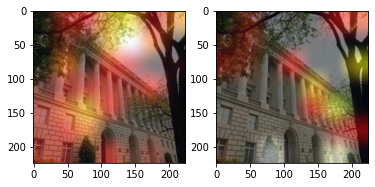

832056
Caption:  Environmental Protection Agency building in Washington DC
Image Caption:  Baldwin Hall at the University of Georgia



Environmental Protection Agency building in Washington DC


Environmental Protection Agency building in Washington DC


Target  1 Prediction  1
 


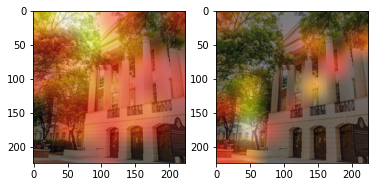

606138
Caption:  An Indian farmer inspects her agricultural field which is badly affected by the heat wave and scanty rainfall in India
Image Caption:  ORIG



An Indian farmer inspects her agricultural field which is badly affected by the heat wave and scanty rainfall in India


An Indian farmer inspects her agricultural field which is badly affected by the heat wave and scanty rainfall in India


Target  0 Prediction  0
 


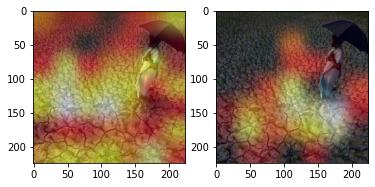

606138
Caption:  An Indian farmer inspects her agricultural field which is badly affected by the heat wave and scanty rainfall in India
Image Caption:  Cracks stretch across the dry bed of Lake Mendocino a key Mendocino County reservoir in Ukiah California



An Indian farmer inspects her agricultural field which is badly affected by the heat wave and scanty rainfall in India


An Indian farmer inspects her agricultural field which is badly affected by the heat wave and scanty rainfall in India


Target  1 Prediction  1
 


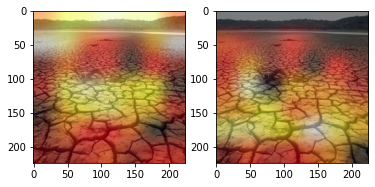

1122148
Caption:  Murdoch University researchers have trialled the use of Judas camels to lead them to feral camel populations in central Australia
Image Caption:  ORIG



Murdoch University researchers have trialled the use of Judas camels to lead them to feral camel populations in central Australia


Murdoch University researchers have trialled the use of Judas camels to lead them to feral camel populations in central Australia


Target  0 Prediction  1
 


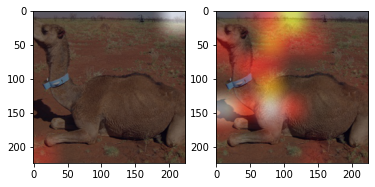

1122148
Caption:  Murdoch University researchers have trialled the use of Judas camels to lead them to feral camel populations in central Australia
Image Caption:  A 2weekold chulengo plays in the private Attica Zoological Park in Spata Greece



Murdoch University researchers have trialled the use of Judas camels to lead them to feral camel populations in central Australia


Murdoch University researchers have trialled the use of Judas camels to lead them to feral camel populations in central Australia


Target  1 Prediction  1
 


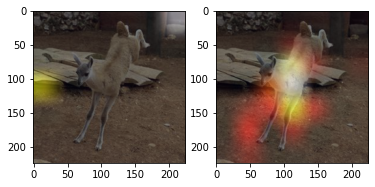

679682
Caption:  The Wilshire Grand tower under construction in downtown Los Angeles
Image Caption:  ORIG



The Wilshire Grand tower under construction in downtown Los Angeles


The Wilshire Grand tower under construction in downtown Los Angeles


Target  0 Prediction  0
 


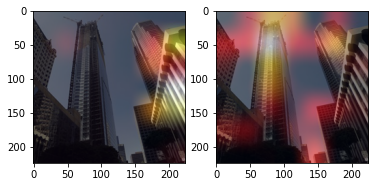

679682
Caption:  The Wilshire Grand tower under construction in downtown Los Angeles
Image Caption:  This is a rendering of the future Hilton Barra in Rio de Janeiro The 298room hotel now under construction is expected to open in June 2014



The Wilshire Grand tower under construction in downtown Los Angeles


The Wilshire Grand tower under construction in downtown Los Angeles


Target  1 Prediction  0
 


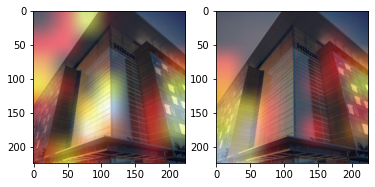

In [185]:
for i in range(20, 50):
    ann = dataset[i]
    print(ann["id"])
    print("Caption: ", ann["caption"])
    print("Image Caption: ", ann["image_caption"])
    print("")
    base_path = "/shared/g-luo/visual_news/origin/"
    imageFile = base_path + ann["image_path"].replace("./", "")
#     categories = [f"an image of {ent[0]}" for ent in ents[ann["id"]]]
    categories = [ann["caption"]]
    if imageFile:
        image_raw = Image.open(imageFile)
        # preprocess image:
        image = preprocess(image_raw).unsqueeze(0).to(device)
        # preprocess text
        # categories = [ann["caption"]]
        text = clip.tokenize(categories).to(device)
        
        get_text_scores(finetuned_model, image, ann, "Finetuned Word Importance")
        get_text_scores(original_model, image, ann, "Original Word Importance")

        finetuned_titles, finetuned_collect_images, finetuned_saliencies = get_grad_cam(finetuned_model, image, text)
        original_titles, original_collect_images, original_saliences = get_grad_cam(original_model, image, text)
        
        if i % 2 == 0:
            predicted = predictions[ann["id"]]
        else: 
            predicted = predictions[ann["id"] * -1]
            
        for i in range(len(finetuned_collect_images)):
            f, ax = plt.subplots(1,2)
            # print("FINETUNED, FREEZE LOWER ", finetuned_titles[i])
            print("Target ", predicted["target"], "Prediction ", predicted["score"])
            ax[0].imshow(finetuned_collect_images[i])
            print(" ")
            # print("ORIGINAL ",original_titles[i])
            ax[1].imshow(original_collect_images[i])
            plt.show()
            
        # get_attention_bbox(ann, finetuned_saliencies[0])
        print("===================================")

    #     print("Original Image and Grad Cam for image embedding")
    #     original, gradcam = Image.fromarray((torch_to_rgba(image[0]).numpy() * 255.).astype(np.uint8)), hm
    #     fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 10))
    #     axes[0].imshow(original)
    #     axes[1].imshow(gradcam)
    #     plt.show()

In [ ]:
# https://github.com/HendrikStrobelt/miniClip
# don't shift the embeddings too much

# want to integrate other knowledge
# use CLIP representation to initialize something
# a new arch?

# analysis of CLIP? Explaining its predictions?
# could "hypothesize" the gt evidence --> looking at person
# evidence should be outside vs on person --> evaluate whether it actually matches (face?)

# where does CLIP get it right? Where does it fail?
# could a model trained with less, domain specific data compete?
# pretrain on all existing news corpora? Is pretraining on this better than on CC?

# compare the objects for highest saliency

In [ ]:
get_attention_bbox(dataset[0])